In [13]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory


In [14]:
train = pd.read_csv('train32.csv')
test = pd.read_csv('test32.csv')
print(train)
print(test)

       index  angle indication_type  indication_value  split
0      48000     40            good                 0  train
1      48001     60            good                 0  train
2      48002     20            good                 0  train
3      48003     40            good                 0  train
4      48004     20            good                 0  train
...      ...    ...             ...               ...    ...
47995  95995     20          thread                 4  train
47996  95996    100          thread                 4  train
47997  95997    120          thread                 4  train
47998  95998    120          thread                 4  train
47999  95999     20          thread                 4  train

[48000 rows x 5 columns]
       index  angle indication_type  indication_value split
0          0     40            good                 0  test
1          1     80            good                 0  test
2          2     60            good                 0  test
3 

In [15]:
# 0: good textile, 1: damaged textile
# Train Data
train['index'] = train['index'] - 48000
train_good = train[train['indication_value'] == 0]
train_damaged = train[train['indication_value'] != 0]
train_damaged['indication_value'] = 1

# Test Data
test['index'] = test['index']
test_good = test[test['indication_value'] == 0]
test_damaged = test[test['indication_value'] != 0]
test_damaged['indication_value'] = 1

C:\Users\pc\AppData\Local\Temp\ipykernel_23792\3269793284.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_damaged['indication_value'] = 1
C:\Users\pc\AppData\Local\Temp\ipykernel_23792\3269793284.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_damaged['indication_value'] = 1


In [16]:
print(test_good.count())
print(test_damaged[test['angle'] == 120].count())
print(test_damaged[test['angle'] == 20].count())

index               8000
angle               8000
indication_type     8000
indication_value    8000
split               8000
dtype: int64
index               5028
angle               5028
indication_type     5028
indication_value    5028
split               5028
dtype: int64
index               4991
angle               4991
indication_type     4991
indication_value    4991
split               4991
dtype: int64


C:\Users\pc\AppData\Local\Temp\ipykernel_23792\486680720.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(test_damaged[test['angle'] == 120].count())
C:\Users\pc\AppData\Local\Temp\ipykernel_23792\486680720.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(test_damaged[test['angle'] == 20].count())


In [17]:
train_table = pd.concat([train_good, train_damaged[train['angle'] == 20], train_damaged[train['angle'] == 120]])
test_table = pd.concat([test_good, test_damaged[test['angle'] == 20], test_damaged[test['angle'] == 120]])

C:\Users\pc\AppData\Local\Temp\ipykernel_23792\291709261.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  train_table = pd.concat([train_good, train_damaged[train['angle'] == 20], train_damaged[train['angle'] == 120]])
C:\Users\pc\AppData\Local\Temp\ipykernel_23792\291709261.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  train_table = pd.concat([train_good, train_damaged[train['angle'] == 20], train_damaged[train['angle'] == 120]])
C:\Users\pc\AppData\Local\Temp\ipykernel_23792\291709261.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  test_table = pd.concat([test_good, test_damaged[test['angle'] == 20], test_damaged[test['angle'] == 120]])
C:\Users\pc\AppData\Local\Temp\ipykernel_23792\291709261.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  test_table = pd.concat([test_good, test_damaged[test['angle'] == 20], test_damaged[test['angle'] == 120

In [18]:
import h5py
import keras

f = h5py.File('train32.h5', 'r')
a_group_key = list(f.keys())[0]
data = list(f[a_group_key])

x_train = []
y_train = []
idx = train_table['index'].astype('int')
indication_value = train_table['indication_value'].astype('int')
for i in idx:
    x_train.append(data[i])
    y_train.append(indication_value.loc[idx[i]])
    
x_train = np.array(x_train)
y_train = np.array(y_train)
y_train = keras.utils.to_categorical(y_train, num_classes=2)

print(x_train.shape)
print(y_train.shape)

(18208, 32, 32, 1)
(18208, 2)


In [19]:
f = h5py.File('test32.h5', 'r')
a_group_key = list(f.keys())[0]
data = list(f[a_group_key])

x_test = []
y_test = []
idx = test_table['index'].astype('int')
indication_value = test_table['indication_value'].astype('int')
for i in idx:
    x_test.append(data[i])
    y_test.append(indication_value.loc[idx[i]])
    
x_test = np.array(x_test)
y_test = np.array(y_test)
y_test = keras.utils.to_categorical(y_test, num_classes=2)

print(x_test.shape)
print(y_test.shape)

(18019, 32, 32, 1)
(18019, 2)


In [20]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import torch.optim as optim
from torchvision.models import resnet18

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Build ResNet50 model
model = resnet18(pretrained = True)
model.conv1 = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3),bias=False)

# Connect to fully connnected layer
model.fc = nn.Sequential(
    nn.Linear(512,512),
    nn.ReLU(inplace=True),
    nn.Linear(512,64),
    nn.ReLU(inplace=True),
    nn.Linear(64,2)
)

def init_weights(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
        nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
        if m.bias is not None:
            nn.init.constant_(m.bias, 0)

model.apply(init_weights)
model.to(device)

C:\Users\pc\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\pc\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


ResNet(
  (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [21]:
from sklearn.model_selection import train_test_split

# Set data loader
class cifar10Dataset(Dataset):
    def __init__(self, imgs, labels, transform=None):
        self.imgs = imgs
        self.labels = labels
        self.transforms = transform

    def __len__(self):
        return len(self.imgs)
    
    def __getitem__(self, index):
        x = self.imgs[index]
        y = self.labels[index]

        if self.transforms:
            x = self.transforms(x)

        x = x.float()
        return x, y

# Split train and validation
x_train, x_val, y_train, y_val = train_test_split(x_train, 
                                                  y_train, 
                                                  test_size=0.2, 
                                                  random_state=100,
                                                  shuffle=True)

learningRate = 0.001
batch_size = 64

# Set loss function and optimiser
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(),lr = learningRate)

# stats = ((0.5), (0.5))
transform = transforms.Compose([transforms.ToTensor(),
                                # transforms.RandomCrop(32, padding=4, padding_mode='reflect'),
                                # transforms.RandomHorizontalFlip(),
                                # transforms.Normalize(*stats,inplace=True)
                               ])

train_dataset = cifar10Dataset(x_train, y_train, transform)
val_dataset = cifar10Dataset(x_val, y_val, transform)
test_dataset = cifar10Dataset(x_test, y_test, transform)
train_loader = DataLoader(dataset=train_dataset, batch_size= batch_size, shuffle=True)
val_loader = DataLoader(dataset=val_dataset, batch_size= batch_size, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size= batch_size, shuffle=True)

In [23]:
# Train loop
num_epoch = 10
best_val_accuracy = 0.0

for epoch in range(num_epoch):
    model.train()
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

    model.eval()
    with torch.no_grad():
        correct = 0
        total = 0
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            _, labels = torch.max(labels, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        val_accuracy = correct / total
        if val_accuracy > best_val_accuracy:
            best_val_accuracy = val_accuracy
            torch.save(model.state_dict(), 'best_model.pth')
        
        print(f'Epoch [{epoch+1}/{num_epoch}], Validation Accuracy: {val_accuracy:.4f}, BEST Accuracy: {best_val_accuracy:.4f}')

print('Training Finished!')

Epoch [1/10], Validation Accuracy: 0.8418, BEST Accuracy: 0.8418
Epoch [2/10], Validation Accuracy: 0.8476, BEST Accuracy: 0.8476
Epoch [3/10], Validation Accuracy: 0.8553, BEST Accuracy: 0.8553
Epoch [4/10], Validation Accuracy: 0.8655, BEST Accuracy: 0.8655
Epoch [5/10], Validation Accuracy: 0.7433, BEST Accuracy: 0.8655
Epoch [6/10], Validation Accuracy: 0.8394, BEST Accuracy: 0.8655
Epoch [7/10], Validation Accuracy: 0.8564, BEST Accuracy: 0.8655
Epoch [8/10], Validation Accuracy: 0.8569, BEST Accuracy: 0.8655
Epoch [9/10], Validation Accuracy: 0.8825, BEST Accuracy: 0.8825
Epoch [10/10], Validation Accuracy: 0.8740, BEST Accuracy: 0.8825
Training Finished!


In [24]:
model.load_state_dict(torch.load('best_model.pth'))
model.eval()

total = 0
correct = 0

for images, labels in test_loader:
    images, labels = images.to(device), labels.to(device)
    batch_outputs = model(images) 
    _, predicted = torch.max(batch_outputs, 1)
    _, labels = torch.max(labels, 1)
    total += labels.size(0)
    correct += (predicted == labels).sum().item()
    
test_accuracy = correct / total
print('Test accuracy: ', test_accuracy)

Test accuracy:  0.8580387368888396


In [25]:
from torchsummary import summary

# Display model summary
summary(model, (1, 32, 32))


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 16, 16]           3,136
       BatchNorm2d-2           [-1, 64, 16, 16]             128
              ReLU-3           [-1, 64, 16, 16]               0
         MaxPool2d-4             [-1, 64, 8, 8]               0
            Conv2d-5             [-1, 64, 8, 8]          36,864
       BatchNorm2d-6             [-1, 64, 8, 8]             128
              ReLU-7             [-1, 64, 8, 8]               0
            Conv2d-8             [-1, 64, 8, 8]          36,864
       BatchNorm2d-9             [-1, 64, 8, 8]             128
             ReLU-10             [-1, 64, 8, 8]               0
       BasicBlock-11             [-1, 64, 8, 8]               0
           Conv2d-12             [-1, 64, 8, 8]          36,864
      BatchNorm2d-13             [-1, 64, 8, 8]             128
             ReLU-14             [-1, 6

In [26]:
import matplotlib.pyplot as plt


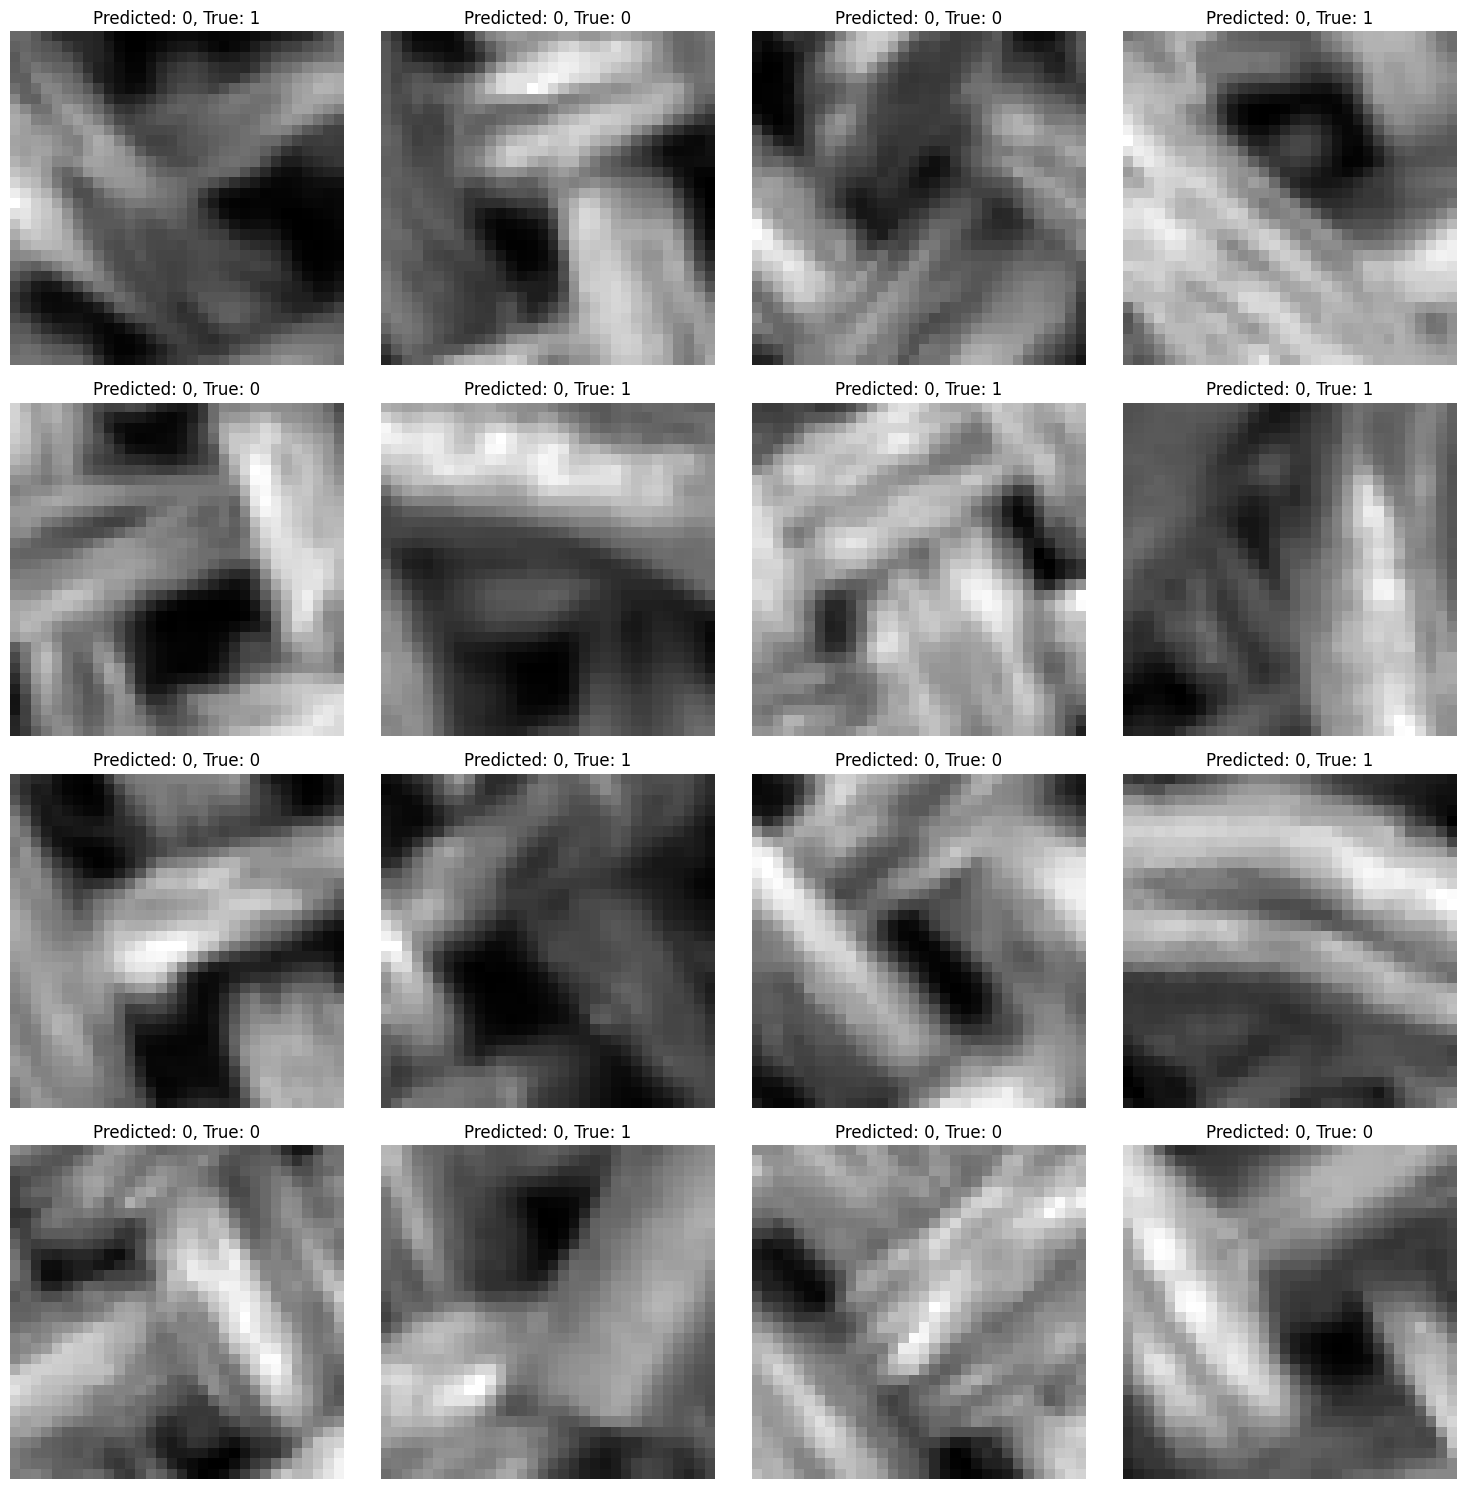

In [27]:
# Function to convert one-hot encoded labels back to integer labels
def convert_to_label(arr):
    return np.argmax(arr)

# Set model to evaluation mode
model.eval()

# Get a batch of test images and labels
images, labels = next(iter(test_loader))
images, labels = images.to(device), labels.to(device)

# Make predictions
outputs = model(images)
_, predicted = torch.max(outputs, 1)

# Display the images along with their predicted labels
fig, axes = plt.subplots(4, 4, figsize=(15, 15))
for i, ax in enumerate(axes.flat):
    ax.imshow(images[i][0].cpu(), cmap='gray')
    ax.axis('off')
    ax.set_title(f'Predicted: {convert_to_label(predicted[i].cpu())}, True: {convert_to_label(labels[i].cpu())}')

plt.tight_layout()
plt.show()